# Synthetic Sonic Log Generation
###### Table of contents
1. [Introduction](#introduction)<br>
    1.1 [Background](#Background)<br>
    1.2 [Problem Statement](#Problem statement)<br>
    1.3 [Data Description](#Data Description)<br>
    1.4 [Evaluation Metric](#Evaluation Metric)<br>
2. [Import Data](#Import Data)<br>
3. [Exploratory Data Analysis](#Exploratory Data Analysis)
4. [Data Cleaning](#Data Cleaning)
5. [Build Machine Learning Models](#Build Machine Learning Models)<br>
    5.1 [Linear Regression Model](#Linear Regression Model)<br>
    5.2 [Linear Regression Model with Regularization](#Linear Regression Model with Regularization)<br>
    5.3 [Random Forest](#Random Forest)<br>
    5.4 [Gradient Boosting Tree](#Gradient Boosting Tree)<br>
    5.5 [Neural Network](#Neural Network)
6. [Model Validation with Test Data](#Model Validation with Test Data)
7. [Summary](#Summary)

In [246]:
# import libraries
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.preprocessing import StandardScaler, Imputer, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold

from hyperopt import hp
from hyperopt import fmin, tpe, Trials, space_eval

from sklearn.linear_model import LinearRegression, RidgeCV, ElasticNet
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.callbacks import ModelCheckpoint
import keras


from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

import xgboost as xgb

import math
from numpy import linalg

from scipy.ndimage import median_filter
import warnings
warnings.filterwarnings('ignore')

## 1. Introduction <a name="introduction"></a>
Introduction Section, taken as it is from the [Starter Notebook](https://github.com/pddasig/Machine-Learning-Competition-2020/blob/master/Synthetic%20Sonic%20Log%20Generation%20Starter_Yu%202_27_2020.ipynb)

## 1.1. Background<a name="Background"></a>
Well logs are interpreted/processed to estimate the in-situ petrophysical and geomechanical properties, which is essential for subsurface characterization. Various types of logs exist, and each provides distinct information about subsurface properties. Certain well logs, like gamma ray (GR), resistivity, density, and neutron logs, are considered as “easy-to-acquire” conventional well logs that are run in most of the wells. Other well logs, like nuclear magnetic resonance, dielectric dispersion, elemental spectroscopy, and sometimes sonic logs, are only run in limited number of wells.

Sonic travel-time logs contain critical geomechanical information for subsurface characterization around the wellbore. Often, sonic logs are required to complete the well-seismic tie workflow or geomechanical properties prediction. When sonic logs are absent in a well or an interval, a common practice is to synthesize them based on its neighboring wells that have sonic logs. This is referred to as sonic log synthesis or pseudo sonic log generation.

## 1.2. Problem Statement<a name="Problem Statement"></a>
Compressional travel-time (DTC) and shear travel-time (DTS) logs are not acquired in all the wells drilled in a field due to financial or operational constraints. Under such circumstances, machine learning techniques can be used to predict DTC and DTS logs to improve subsurface characterization. The goal of the “SPWLA’s 1st Petrophysical Data-Driven Analytics Contest” is to develop data-driven models by processing “easy-to-acquire” conventional logs from Well #1, and use the data-driven models to generate synthetic compressional and shear travel-time logs (DTC and DTS, respectively) in Well #2. A robust data-driven model for the desired sonic-log synthesis will result in low prediction errors, which can be quantified in terms of Root Mean Squared Error by comparing the synthesized and the original DTC and DTS logs.

You are provided with two datasets: train.csv and test.csv. You need to build a generalizable data-driven models using train dataset. Following that, you will deploy the newly developed data-driven models on test dataset to predict DTS and DTC logs. The data-driven model should use feature sets derived from the following 7 logs: Caliper, Neutron, Gamma Ray, Deep Resistivity, Medium Resistivity, Photo-electric factor and density. The data-driven model should synthesize two target logs: DTC and DTS logs.

The predicted values should be in the same format as sample_submission.csv, and submit together with your notebook for evaluation.

## 1.3. Data Decription<a name="Data Decription"></a>
> #### train.csv All the values equals to -999 are marked as missing values.

CAL - Caliper, unit in Inch,<br>
CNC - Neutron, unit in dec,<br>
GR - Gamma Ray, unit in API,<br>
HRD - Deep Resisitivity, unit in Ohm per meter,<br>
HRM - Medium Resistivity, unit in Ohm per meter,<br>
PE - Photo-electric Factor, unit in Barn,<br>
ZDEN - Density, unit in Gram per cubit meter,<b4>
DTC - Compressional Travel-time, unit in nanosecond per foot,<br>
DTS - Shear Travel-time, unit in nanosecond per foot,<br>
> #### test.csv The test data has all features that you used in the train dataset, except the two sonic curves DTC and DTS.

> #### sample_submission.csv A valid sample submission.

## 1.4. Evaluation Metric<a name="Evaluation Metric"></a>
We will be evaluated by the metirc Root Mean Squared Error.

The RMSE is calculated as:

$ ϵ=\sum_i \sqrt{ \sum_n (y_p - y_t)^2 /n } $

Where:

y_p is the predicted curve for DTC and DTS
y_t is the true value for evaluation.
DTC and DTS are in the same weight during the evaluation

Understanding and optimizing your predictions for this evaluation metric is paramount for this compeition.

## 2. Import Data<a name="Import Data"></a>

In [378]:
file_path = './Data3_1_2020/'
#training dataset
df1 = pd.read_csv(file_path+'train.csv')
#test dataset
df2 = pd.read_csv(file_path+'test.csv')

In [379]:
df1.shape

(30143, 9)

In [380]:
df2.shape

(11088, 7)

In [381]:
df1.columns.tolist()

['CAL', 'CNC', 'GR', 'HRD', 'HRM', 'PE', 'ZDEN', 'DTC', 'DTS']

In [382]:
df2.columns.tolist()

['CAL', 'CNC', 'GR', 'HRD', 'HRM', 'PE', 'ZDEN']

In [383]:
df1.describe()

CAL           CNC            GR           HRD           HRM  \
count  30143.000000  30143.000000  30143.000000  30143.000000  30143.000000   
mean      -8.394576    -23.692615     38.959845      3.977690      1.547299   
std      129.970219    157.142679    108.504554    365.112753    456.908969   
min     -999.000000   -999.000000   -999.000000   -999.000000   -999.000000   
25%        8.058350      0.122800     17.248750      0.717700      0.712050   
50%        8.625000      0.193600     36.821800      1.623000      1.628100   
75%        9.048850      0.337150     58.346150      3.158300      3.280600   
max       21.064200   3490.158200   1470.253400  10000.000000  60467.761700   

                 PE          ZDEN           DTC           DTS  
count  30143.000000  30143.000000  30143.000000  30143.000000  
mean     -17.446739    -20.229982    -54.891703     -9.737567  
std      149.083136    148.809506    372.858812    440.314119  
min     -999.000000   -999.000000   -999.000000   -999.000000  
25%        0.053100      2.226700     66.304350    118.534350  
50%        4.941500      2.432200     78.355100    137.689300  
75%        7.856650      2.551350    107.022500    182.973150  
max       28.106400      3.259700    155.980300    487.438400

Summary:
    In total, training data include 7 features and 2 targets. And test data have the same features as in the trainign dataset. 30143 entries of data were found in the training dataset.

## 3. Exploratory Data Analysis<a name="Exploratory Data Analysis"></a>

In [384]:
def plot_profile(data):
    plt.figure(figsize = (25,16))
    plt.title('Well Log Variable Profiles')
    y_tmp = range(data.shape[0])
    var = ['CAL','GR', 'CNC', 'ZDEN', 'PE', 'HRD','DTC']
    scales = [[0,35],[-50, 250], [-0.15, 1], [1, 4], [-5,30], [0.2, 5], [30,500]]
    for i in range(len(var)):
        plt.subplot(171+i)
        plt.plot(var[i], y_tmp, data = data)
        plt.xlim(scales[i])
        plt.ylim([0,33000])
        if var[i] == 'HRD':
            plt.plot('HRM', y_tmp, data = data, c = 'red', label = 'HRM')
        elif var[i] == 'DTC':
            plt.plot('DTS', y_tmp, data = data, c = 'red', label = 'HRM')
        plt.gca().invert_yaxis()
        plt.title(var[i])

In [385]:
df1.tail()

CAL     CNC        GR     HRD     HRM      PE    ZDEN      DTC  \
30138  8.6719  0.1879  119.9486  2.5130  2.5187  0.0597  2.6240  74.2133   
30139  8.6719  0.1825  122.5286  2.5011  2.4818  0.0582  2.6194  74.3503   
30140  8.6797  0.1774  122.0544  2.5010  2.4717  0.0571  2.6169  74.4752   
30141  8.6719  0.1744  120.6518  2.5150  2.5007  0.0562  2.6159  74.5917   
30142  8.6719  0.1742  120.5270  2.5211  2.5068  0.0552  2.6155  74.7082   

            DTS  
30138  131.7747  
30139  132.2201  
30140  132.5171  
30141  132.7115  
30142  132.9060

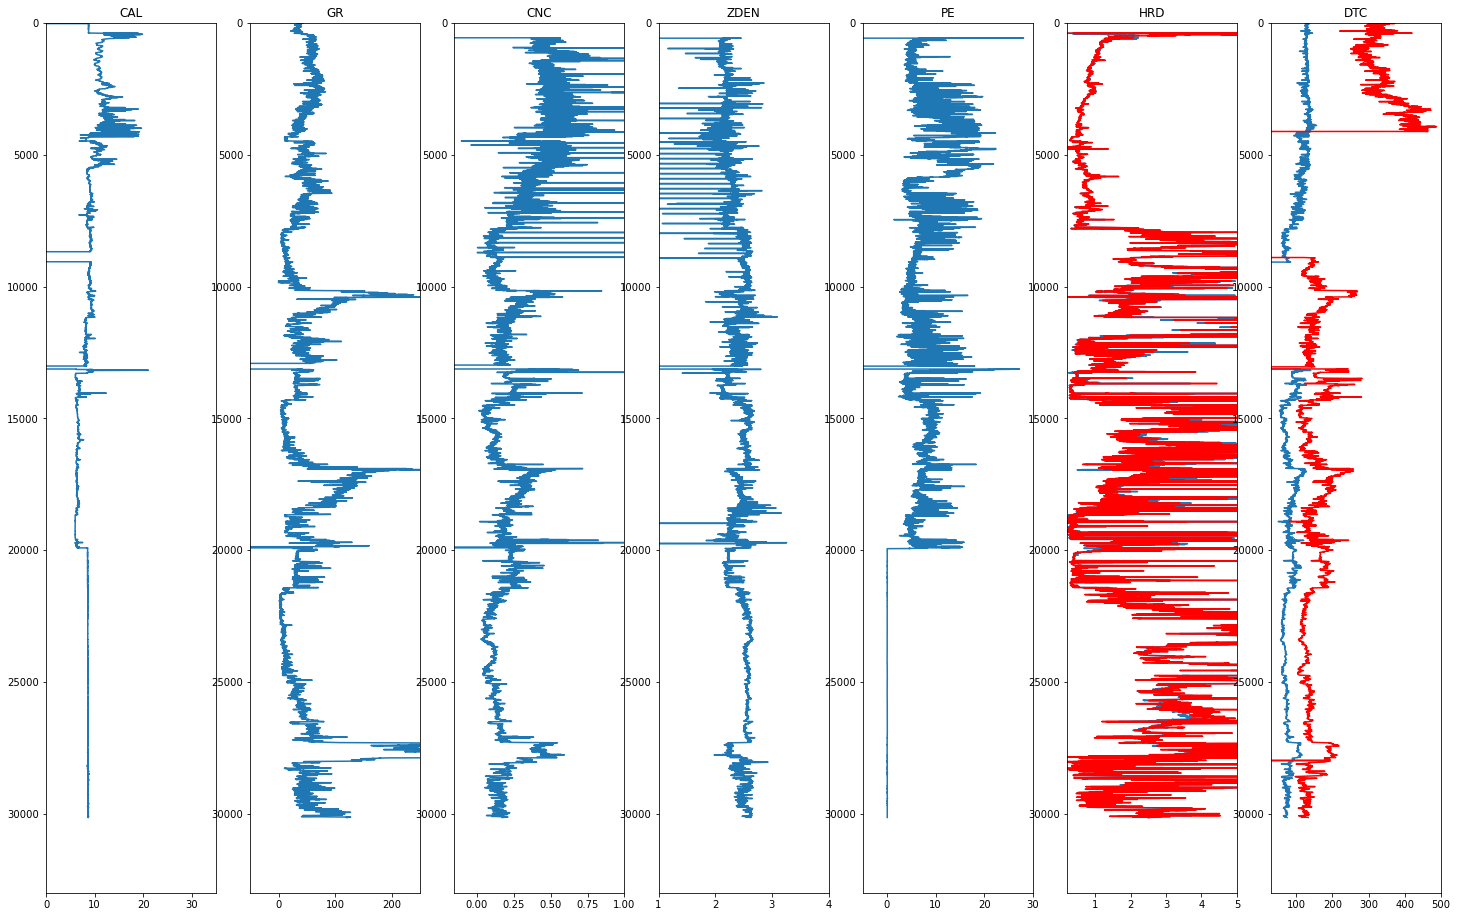

In [386]:
plot_profile(df1)

#### Summary of the profile plot 
CAL: In the range of depth index 0-5000, the data is not very stable.<br>
GR: Large values found at depth_index near 10000, 17000 and 27000.<br>
CNC: In the range of depth index 0-10000, the data variation is lager than the deeper .<br>
ZEN: Similar to CNC, in the range of 0-1000, data variation is slightly larger.<br>
PE: Suspicious value found below depth index 20000.<br>
HRD&HRM: The data variation is smaller at depth index range 0-7000.<br>
DTC&DTS: The DTS is clearly larger at depth index 0-5000.The ratio between DTC and DTS was quite similar in the deep.<br>

In [390]:
# Delete points where data are missing 
df1=df1[['CNC','GR','ZDEN','HRD','DTC','DTS','CAL','HRM','PE']]
df1.replace(['-999', -999], np.nan, inplace=True)

df2=df2[['CNC','GR','ZDEN','HRD','CAL','HRM','PE']]
df2.replace(['-999', -999], np.nan, inplace=True)

In [391]:
df1.isnull().sum()

CNC      735
GR       254
ZDEN     681
HRD      385
DTC     4054
DTS     4865
CAL      510
HRM      385
PE       679
dtype: int64

In [392]:
df2.isnull().sum()

CNC     0
GR      0
ZDEN    0
HRD     0
CAL     0
HRM     0
PE      0
dtype: int64

In [393]:
#delete the rows with nan value
df1.dropna(axis=0, inplace=True)
df2.dropna(axis=0, inplace=True)

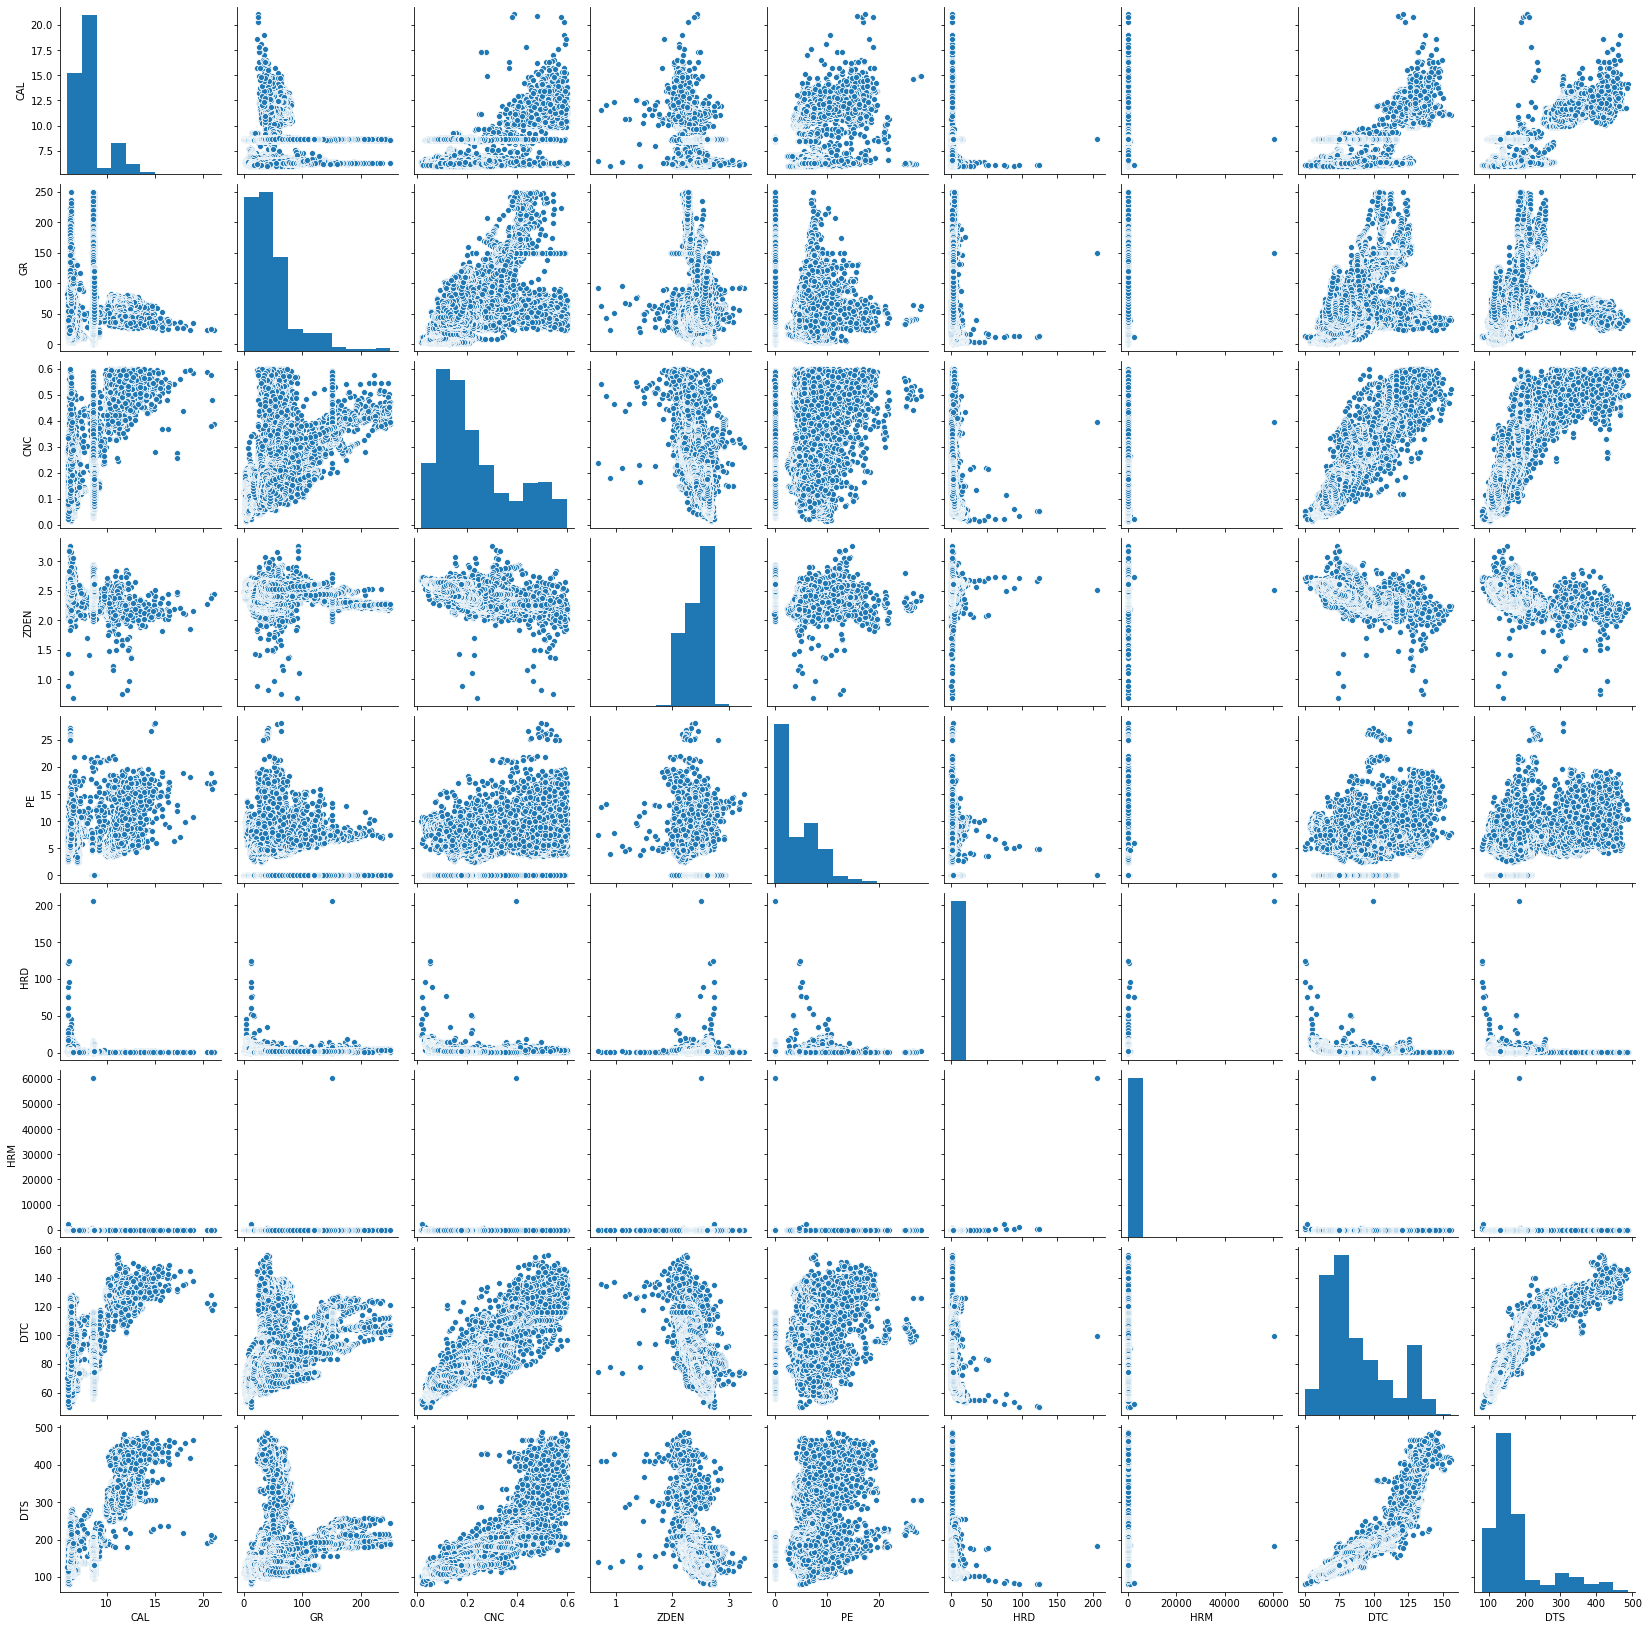

In [15]:
df_plot=df1.copy()
df_plot['CNC'][df_plot['CNC']>0.6]=np.nan
df_plot['CNC'][df_plot['CNC']<-0.15]=np.nan
df_plot['GR'][df_plot['GR']>250]=150
df_plot.dropna(axis=0, inplace=True)
g=sb.pairplot(df_plot[['CAL','GR', 'CNC', 'ZDEN', 'PE', 'HRD','HRM','DTC','DTS']])

In [394]:
#Perform logrithmic transformation to resistivity logs to avoid large weight on resisitivity logs
df1['HRD_log']=np.log(df1.HRD.values)
df2['HRD_log']=np.log(df2.HRD.values)
df1['HRM_log']=np.log(df1.HRM.values)
df2['HRM_log']=np.log(df2.HRM.values)

<Figure size 1800x1152 with 0 Axes>

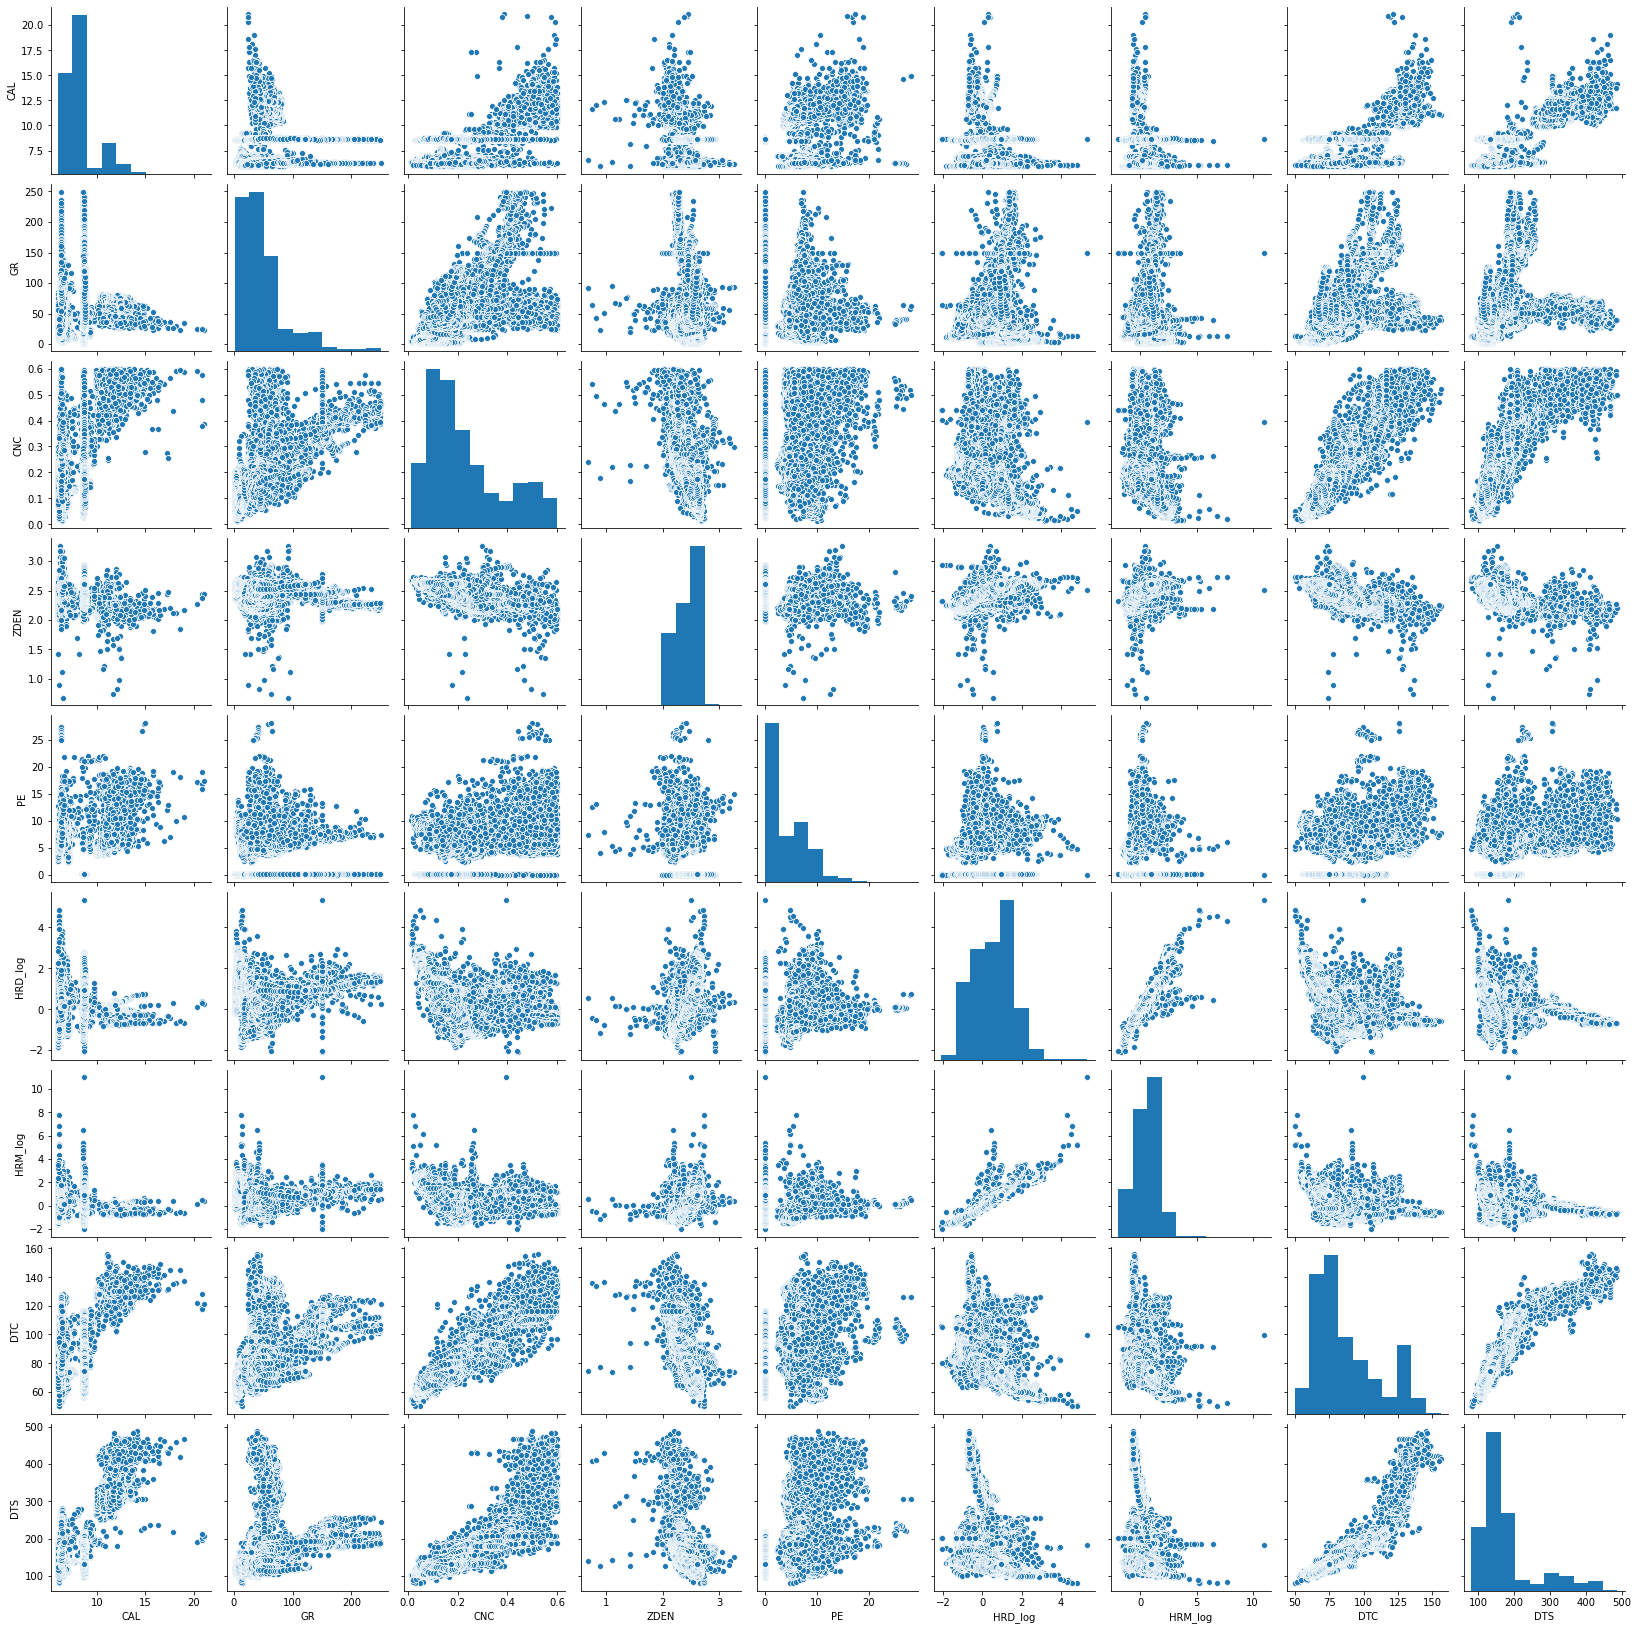

In [395]:
df_plot=df1.copy()
df_plot['CNC'][df_plot['CNC']>0.6]=np.nan
df_plot['CNC'][df_plot['CNC']<-0.15]=np.nan
df_plot['GR'][df_plot['GR']>250]=150
#df_plot['HRD_log'][df_plot['HRD_log']>150] = np.nan
#df_plot['HRM_log'][df_plot['HRM_log']>150] = np.nan
df_plot.dropna(axis=0, inplace=True)
g=sb.pairplot(df_plot[['CAL','GR', 'CNC', 'ZDEN', 'PE', 'HRD_log','HRM_log','DTC','DTS']])

### From the pair scatter plots we can found:
DTC and DTS are obviously correlated with CAL, GR, CNC<br>
Among the features, HRM and HRD are strongly correlated<br>
Some obcscure relationship can be observed between GR and CNC<br>

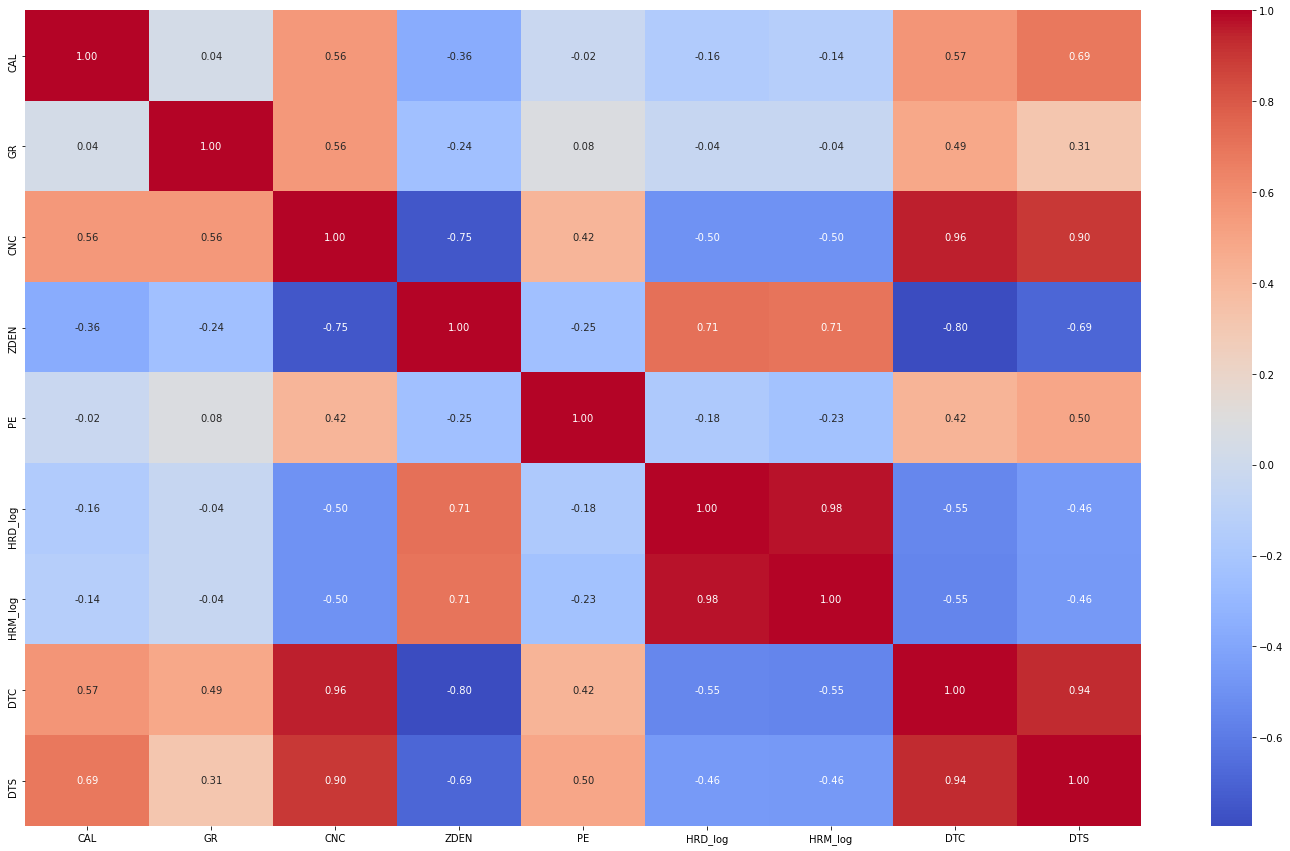

In [18]:
fig, ax = plt.subplots(figsize = (25,15))
cm_df = sb.heatmap(df_plot[['CAL','GR', 'CNC', 'ZDEN', 'PE', 'HRD_log','HRM_log','DTC','DTS']].corr(), annot = True, fmt = ".2f", cmap = 'coolwarm', ax = ax)

In [19]:
cm_df = sb.heatmap(df_plot[['CAL','GR', 'CNC', 'ZDEN', 'PE', 'HRD_log','HRM_log','DTC','DTS']].corr(), annot = True, fmt = ".2f", cmap = 'coolwarm', ax = ax)

### Summary of correlation matrix 
CAL, CNC, ZDEN are strong indicators of the targes <br>
Similar to the observation from the paired plots, HRD and HRM are strongly correlated <br>
ZEN and CNC are negatively correlated <br>

## 4. Data Cleaning<a name="Data Cleaning"></a>

In [22]:
df2.describe()

CNC            GR          ZDEN           HRD           CAL  \
count  11088.000000  11088.000000  11088.000000  11088.000000  11088.000000   
mean       0.158501     28.966414      2.475884      4.028372      8.634049   
std        0.091298     43.648163      0.149440      7.198112      0.044064   
min        0.009800      0.852000      2.033400      0.083900      8.500000   
25%        0.091700      8.449450      2.378175      1.760775      8.625000   
50%        0.128300     18.168650      2.533600      2.758900      8.625000   
75%        0.213500     36.470725      2.581800      4.539675      8.671900   
max        0.559400   1124.442000      3.024800    202.233000      8.875000   

                HRM            PE       HRD_log       HRM_log  
count  11088.000000  11088.000000  11088.000000  11088.000000  
mean     106.752210      7.353522      0.931665      1.036167  
std     2374.620246      1.239075      0.946956      1.105914  
min        0.102700      4.760800     -2.478130     -2.275943  
25%        1.865575      6.528075      0.565754      0.623569  
50%        3.176950      7.881700      1.014832      1.155922  
75%        5.034600      8.308325      1.512855      1.616334  
max    62290.769500     13.840700      5.309420     11.039569

In [23]:
df1.describe()

CNC            GR          ZDEN           HRD           DTC  \
count  20525.000000  20525.000000  20525.000000  20525.000000  20525.000000   
mean       0.274416     49.889253      2.410734      2.598719     88.312221   
std        3.062495     54.811017      0.181713      3.465665     23.542419   
min        0.014500      1.038900      0.680600      0.123600     49.970500   
25%        0.120300     16.036800      2.236100      0.810000     70.423100   
50%        0.187700     37.498000      2.466500      1.814900     79.695400   
75%        0.329000     61.140700      2.563700      3.337400    102.482800   
max      365.885000   1470.253400      3.259700    206.718200    155.980300   

                DTS           CAL           HRM            PE       HRD_log  \
count  20525.000000  20525.000000  20525.000000  20525.000000  20525.000000   
mean     182.051067      8.426679      5.835466      3.833792      0.507259   
std       84.670122      1.845912    422.449589      4.375818      0.959167   
min       80.580400      5.930400      0.134100     -0.023200     -2.090705   
25%      127.148800      6.629100      0.797300      0.049800     -0.210721   
50%      142.678500      8.578100      1.829300      3.287800      0.596030   
75%      192.757800      8.671900      3.463300      7.061300      1.205192   
max      487.438400     21.064200  60467.761700     28.106400      5.331357   

            HRM_log  
count  20525.000000  
mean       0.522865  
std        0.975367  
min       -2.009169  
25%       -0.226524  
50%        0.603933  
75%        1.242222  
max       11.009866

From the reference and test dataset statistics, we think the following should be applied to training dataset:<br>
CNC should range from 0.0 to 1.0<br>
GR should not have values less than 0.0<br>
PE should not have values less than 0.0<br>
ZDEN should not have values less than 0.0<br>

In [20]:
#Limit CNC to range between 0.0 and 1.0
df1['CNC'].loc[df1['CNC'] < 0] = np.nan
df1['CNC'].loc[df1['CNC'] > 1] = np.nan
#Limit PE to have values no less than 0.0
df1['PE'].loc[df1['PE']<0] = np.nan
df1['GR'].loc[df1['GR']>300] = np.nan
df1.dropna(axis=0, inplace=True)

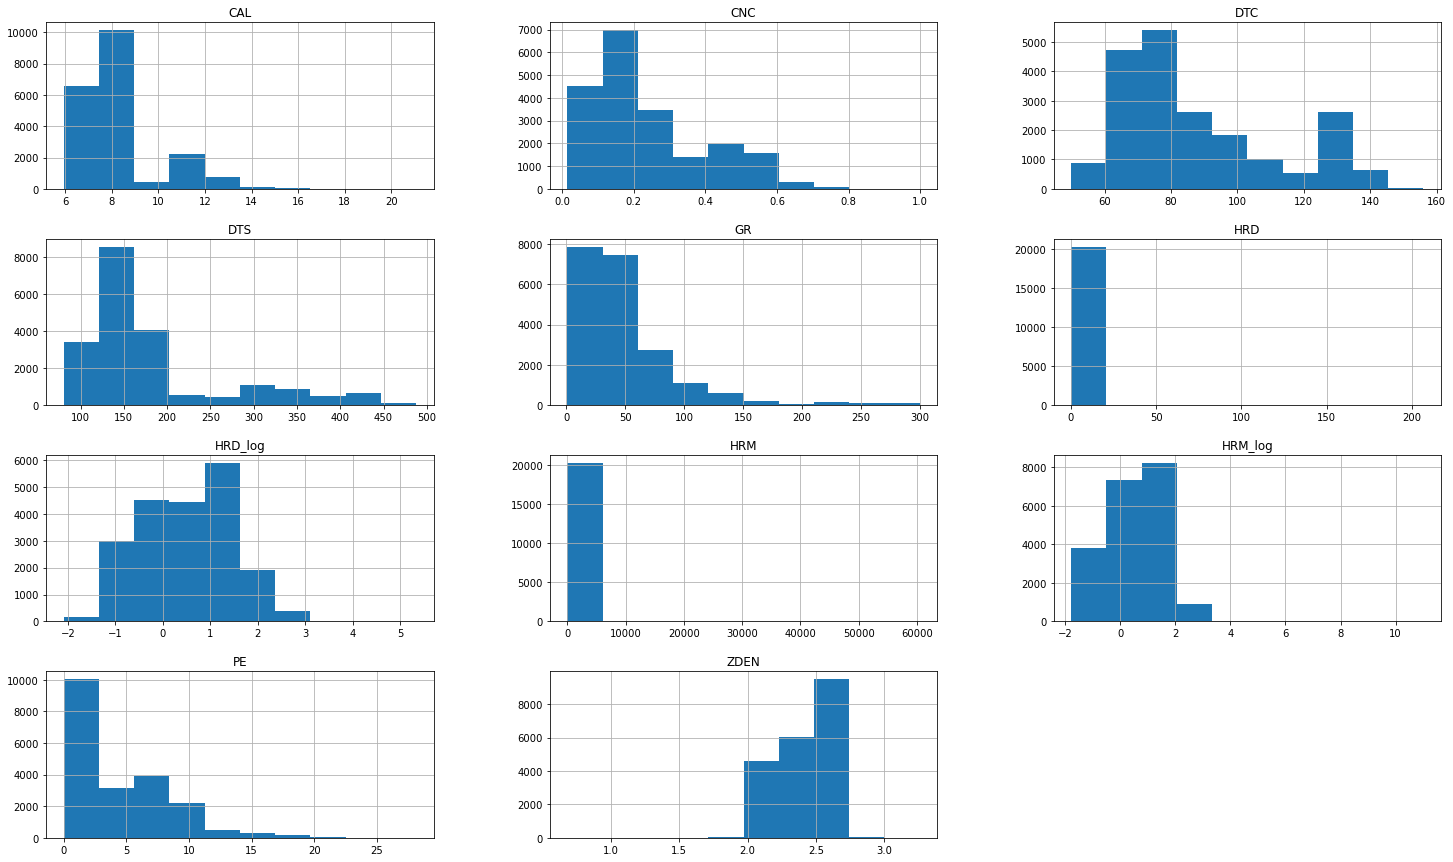

In [21]:
fig, ax = plt.subplots(figsize = (25,15))
hist = df1.hist(ax = ax)

## 5. Build Machine Learning Models<a name="Build Machine Learning Models"></a>

### 5.1 Linear Regression Model<a name="Linear Regression Model"></a>

In [311]:
#seperate the features and targes
df1_y = df1[['DTC','DTS']]
df1_x = df1[['CAL','GR', 'CNC', 'ZDEN', 'PE', 'HRD_log','HRM_log']] 

In [312]:
#standize the matrix for training data
# Minmax scaling is used to constrain the range of the output.
scaler_X = StandardScaler() 
scaler_y = StandardScaler() 
x_scl = scaler_X.fit_transform(df1_x.values)   
y_scl = scaler_y.fit_transform(df1_y.values)

In [313]:
#train/test split
X_train, X_test, y_train, y_test = train_test_split(x_scl, y_scl, test_size = 0.2, random_state = 22)

In [167]:
clf = LinearRegression()
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
y_predict = scaler_y.inverse_transform(y_predict)
y_true = scaler_y.inverse_transform(y_test)

In [168]:
def result_plot(y_predict, y_real):
    # check the accuracy of predicted data and plot the result
    print('Root Mean Square Error is:', '{:.5f}'.format(np.sqrt(mean_squared_error(y_real, y_predict))))
    plt.subplots(nrows=2, ncols=2, figsize=(16,10))
    plt.subplot(2, 2, 1)
    plt.plot(y_real[:, 0])
    plt.plot(y_predict[:, 0])
    plt.ylim([0,200])
    plt.legend(['True', 'Predicted'])
    plt.xlabel('Sample')
    plt.ylabel('DTC')
    plt.title('DTC Prediction Comparison')

    plt.subplot(2, 2, 2)
    plt.plot(y_real[:, 1])
    plt.plot(y_predict[:, 1])
    plt.ylim([0,500])
    plt.legend(['True', 'Predicted'])
    plt.xlabel('Sample')
    plt.ylabel('DTS')
    plt.title('DTS Prediction Comparison')
    
    plt.subplot(2, 2, 3)
    plt.scatter(y_real[:, 0], y_predict[:, 0])
    plt.xlabel('Real Value')
    plt.ylabel('Predicted Value')
    plt.title('DTC Prediction Comparison')
    
    plt.subplot(2, 2, 4)
    plt.scatter(y_real[:, 1], y_predict[:, 1])
    plt.xlabel('Real Value')
    plt.ylabel('Predicted Value')
    plt.title('DTS Prediction Comparison')

    plt.show()

Root Mean Square Error is: 18.07646


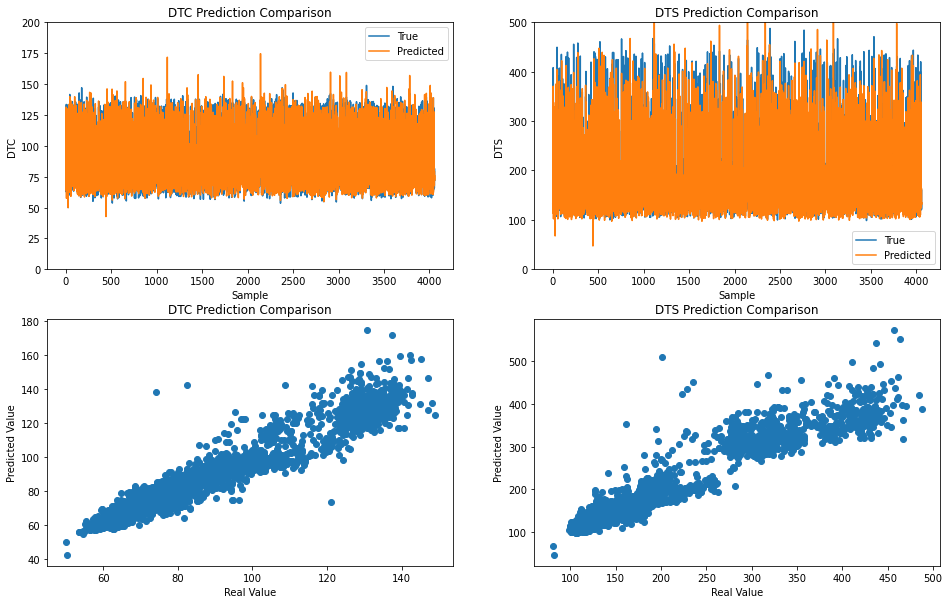

In [169]:
result_plot(y_predict, y_true)

### 5.2 Linear Regression Model with Regularization<a name="Linear Regression Model with Regularization"></a>

In [170]:
clf2 = ElasticNet()
space = {'l1_ratio':hp.choice('l1_ratio',np.arange(0,1.01,0.25)),
        'alpha':hp.choice('alpha',np.arange(0.1,1.0,0.2))}

In [171]:
def objective(space):
    clf2.set_params(**space)
    shuffle = KFold(n_splits=5, shuffle=True)
    score = cross_val_score(clf2, X_train, y_train, cv=shuffle, scoring='r2', n_jobs=1)
    return 1-score.mean()

In [172]:
trials = Trials()
best = fmin(objective,
            space,
            algo=tpe.suggest,
            max_evals=10,
            trials=trials)

100%|███████████████████████████████████████████████| 10/10 [00:00<00:00, 41.09trial/s, best loss: 0.08324558458624876]


In [173]:
best_params = space_eval(space, best)

In [174]:
clf2.set_params(**best_params)

ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.25,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [175]:
clf2.fit(X_train, y_train)

ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.25,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [176]:
y_predict = clf2.predict(X_test)
y_predict = scaler_y.inverse_transform(y_predict)

Root Mean Square Error is: 18.62349


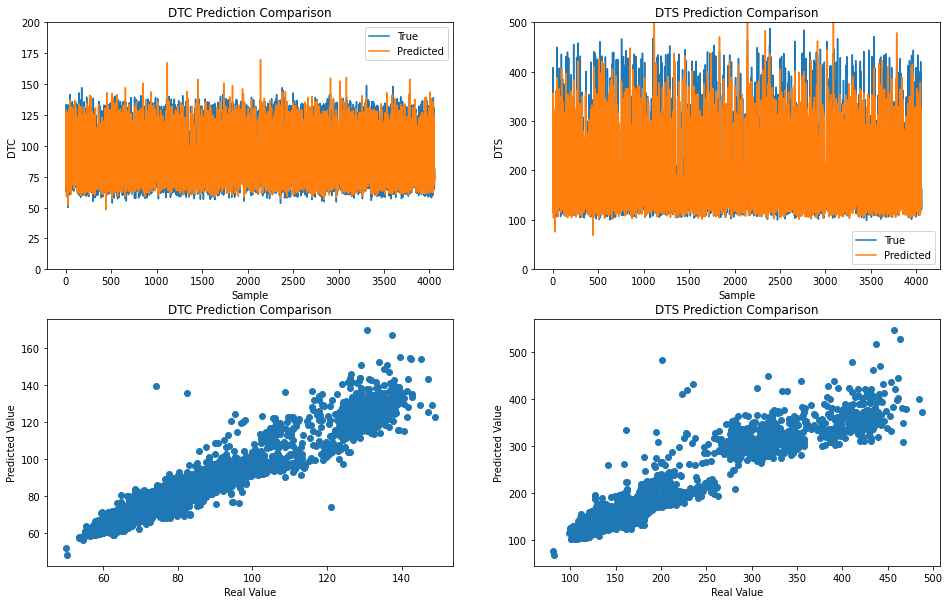

In [177]:
result_plot(y_predict, y_true)

### 5.3 Random Forest<a name="Random Forest"></a>

In [403]:
RF = RandomForestRegressor(n_jobs=-1, random_state=100)
space = {'n_estimators':hp.choice('n_estimators',range(100,1000,10)),
        'criterion':hp.choice('criterion',['mse', 'mae']),
        'max_depth':hp.quniform('max_depth',2,10,2),
        'min_samples_split':hp.choice('min_samples_split',range(2,5,1))         
}

In [404]:
RF.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=100, verbose=0, warm_start=False)

In [405]:
y_predict = RF.predict(X_test)
y_predict = scaler_y.inverse_transform(y_predict)

Root Mean Square Error is: 6.04730


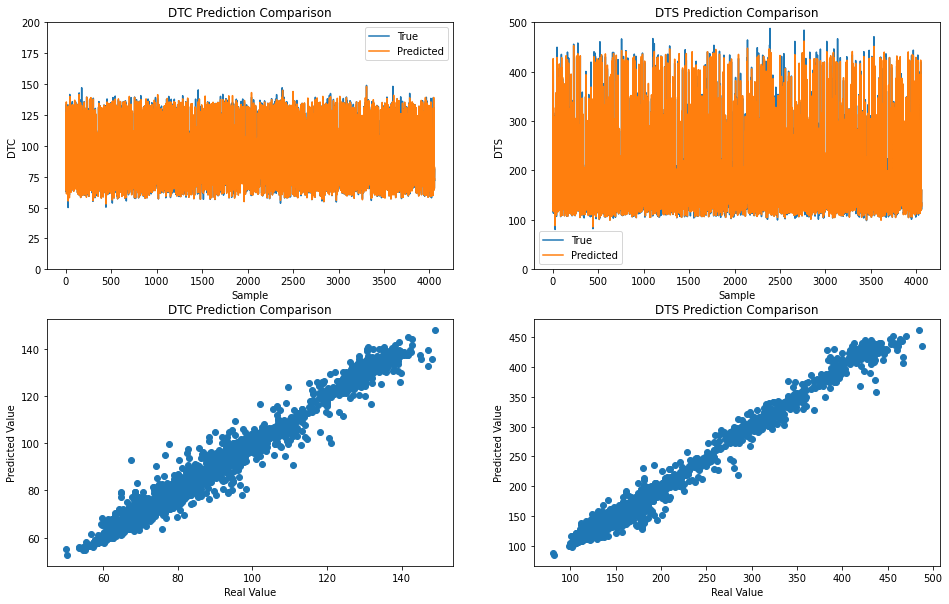

In [406]:
result_plot(y_predict, y_true)

In [407]:
def objective(space):
    RF.set_params(**space)
    shuffle = KFold(n_splits=3, shuffle=True)
    score = cross_val_score(RF, X_train, y_train, cv=shuffle, scoring='r2', n_jobs=-1)
    return 1-score.mean()

In [408]:
trials = Trials()
best = fmin(objective,
            space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)

  0%|                                                                           | 0/50 [00:04<?, ?trial/s, best loss=?]


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



In [ ]:
best_params = space_eval(space, best)
RF.set_params(**best_params)

In [ ]:
y_predict = RF.predict(df1_x_scl)

In [ ]:
result_plot(y_predict, df1_y)

### 5.4 Gradient Boosting Tree<a name="Gradient Boosting Tree"></a>

In [418]:
y_train_dtc = y_train[:,-2]
y_train_dts = y_train[:,-1]

In [424]:
from hyperopt.pyll.base import scope
xgb_dtc = xgb.XGBRegressor(random_state=42)
space ={
        'n_estimators' : scope.int(hp.quniform('n_estimators', 50, 1000, 1)),
        'learning_rate': hp.quniform('eta', 0.025, 0.5, 0.025),
        'max_depth': scope.int(hp.quniform("x_max_depth", 2, 10, 2)),
        'min_child_weight' : scope.int(hp.quniform('min_child_weight', 2, 6, 1)),
        'subsample' : hp.quniform('subsample', 0.7, 1.0, 0.1),
        'gamma' : hp.quniform('gamma',0.1,0.5,0.1)
    }     

In [425]:
def objective(space):
    xgb_dtc.set_params(**space)
    shuffle = KFold(n_splits=5, shuffle=True)
    score = cross_val_score(xgb_dtc, X_train, y_train_dtc, cv=shuffle, scoring='r2', n_jobs=-1)
    return 1-score.mean()

In [426]:
trials = Trials()
best_dtc = fmin(objective,
            space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

100%|████████████████████████████████████████████| 100/100 [48:09<00:00, 28.90s/trial, best loss: 0.015643643807634833]


In [427]:
print(best_dtc)

{'eta': 0.07500000000000001, 'gamma': 0.1, 'min_child_weight': 3.0, 'n_estimators': 700.0, 'subsample': 0.8, 'x_max_depth': 10.0}


In [428]:
xgb_dts = xgb.XGBRegressor(random_state=42)

In [429]:
def objective(space):
    xgb_dts.set_params(**space)
    shuffle = KFold(n_splits=5, shuffle=True)
    score = cross_val_score(xgb_dts, X_train, y_train_dts, cv=shuffle, scoring='r2', n_jobs=-1)
    return 1-score.mean()

In [430]:
trials = Trials()
best_dts = fmin(objective,
            space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

100%|████████████████████████████████████████████| 100/100 [46:05<00:00, 27.66s/trial, best loss: 0.010355750304189781]


In [431]:
print(best_dts)

{'eta': 0.025, 'gamma': 0.1, 'min_child_weight': 5.0, 'n_estimators': 915.0, 'subsample': 0.8, 'x_max_depth': 10.0}


In [432]:
best_params = space_eval(space, best_dtc)
xgb_dtc.set_params(**best_params)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.1, learning_rate=0.07500000000000001,
       max_delta_step=0, max_depth=10, min_child_weight=3, missing=None,
       n_estimators=700, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.8)

In [433]:
best_params = space_eval(space, best_dts)
xgb_dts.set_params(**best_params)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.1, learning_rate=0.025,
       max_delta_step=0, max_depth=10, min_child_weight=5, missing=None,
       n_estimators=915, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.8)

In [434]:
xgb_dtc.fit(X_train, y_train_dtc)
y_predict_dtc=xgb_dtc.predict(X_test)
xgb_dts.fit(X_train, y_train_dts)
y_predict_dts=xgb_dts.predict(X_test)

In [435]:
y_predict = np.concatenate((y_predict_dtc.reshape(-1,1),y_predict_dts.reshape(-1,1)),axis=1)
y_predict = scaler_y.inverse_transform(y_predict)

Root Mean Square Error is: 6.25234


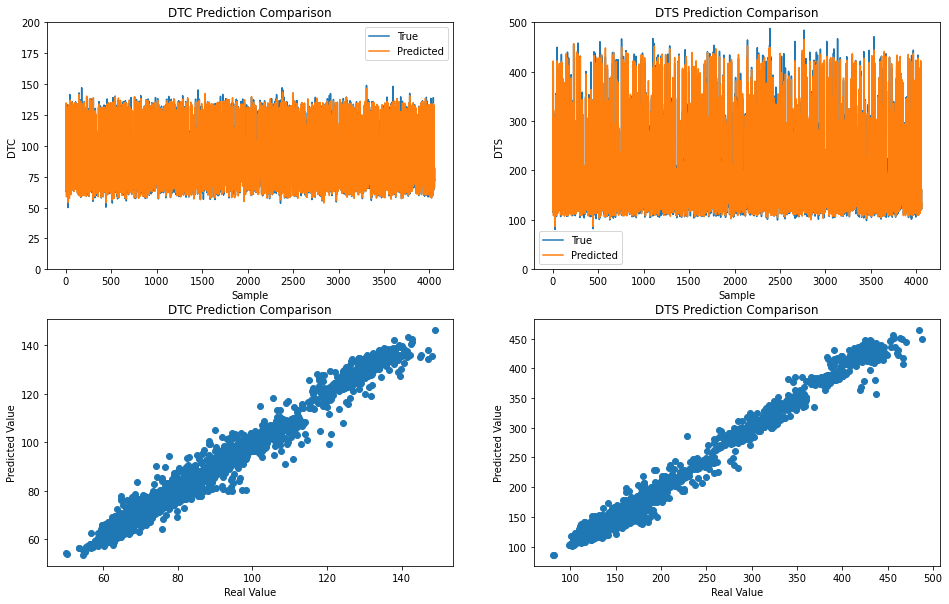

In [436]:
result_plot(y_predict, y_true)

In [364]:
#model for DCT
y_train_dtc = y_train[:,-2]
xgb_dtc = xgb.XGBRegressor(random_state=42, max_depth=2,learning_rate=0.05, n_estimators=145, min_child_weight = 6, gamma = 0.3)

In [365]:
xgb_dtc.fit(X_train, y_train_dtc)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.3, learning_rate=0.05, max_delta_step=0,
       max_depth=2, min_child_weight=6, missing=None, n_estimators=145,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [366]:
y_predict_dtc=xgb_dtc.predict(X_test)

In [367]:
#model for DTS
y_train_dts = y_train[:,-1]
xgb_dts = xgb.XGBRegressor(random_state=42, max_depth=2,learning_rate=0.05, n_estimators=145, min_child_weight = 6, gamma = 0.3)

In [368]:
xgb_dts.fit(X_train, y_train_dts)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.3, learning_rate=0.05, max_delta_step=0,
       max_depth=2, min_child_weight=6, missing=None, n_estimators=145,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [369]:
y_predict_dts=xgb_dts.predict(X_test)

In [370]:
y_predict_dts.T

array([-0.5697508 , -0.7155851 , -0.25125164, ..., -0.5876039 ,
       -0.5960953 , -0.47429556], dtype=float32)

In [371]:
y_predict = np.concatenate((y_predict_dtc.reshape(-1,1),y_predict_dts.reshape(-1,1)),axis=1)
y_predict = scaler_y.inverse_transform(y_predict)

Root Mean Square Error is: 9.66235


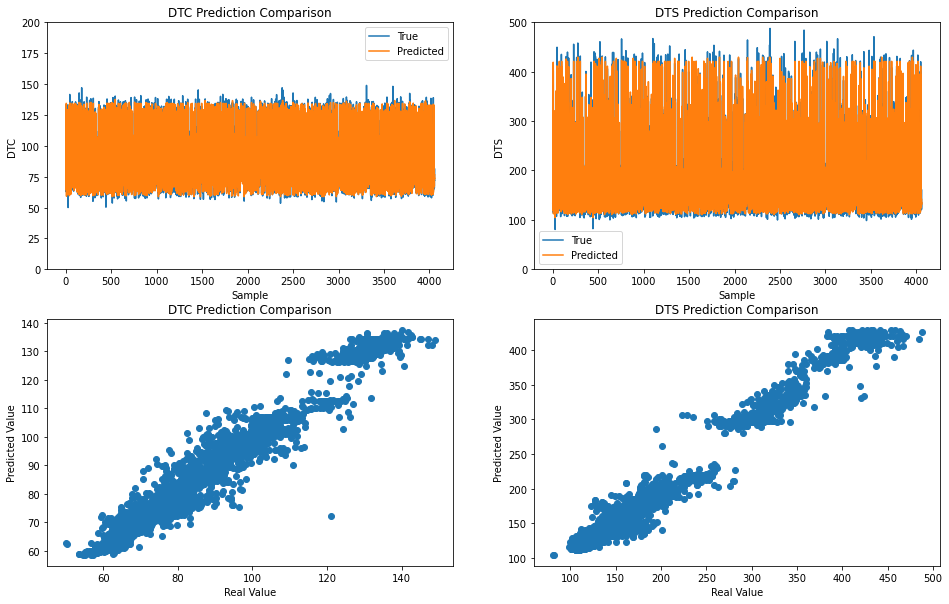

In [372]:
result_plot(y_predict, y_true)

### 5.4 Neural Network<a name="Neural Network"></a>

In [196]:
scaler_X_mm = MinMaxScaler() 
scaler_y_mm = MinMaxScaler() 
x_scl1 = scaler_X_mm.fit_transform(df1_x.values)   
y_scl1 = scaler_y_mm.fit_transform(df1_y.values)

x_scl1 =np.concatenate([x_scl1[1:-1],x_scl1[0:-2],x_scl1[2:]],axis=-1)    
y_scl1 = y_scl1[1:-1]

X_train, X_test, y_train, y_test = train_test_split(x_scl1, y_scl1, test_size = 0.2, random_state = 22)

# A simple fully connected neural network is used for prediction
model_1 = Sequential([
    Dense(24, activation='relu', input_shape=(21,)),
    Dense(12, activation='relu'),
    Dense(2,activation='sigmoid'),
])



model_1.compile(optimizer='adam', loss='mse', metrics=['mae'])
np.random.seed(1)
set_random_seed(2)

save_model_name = 'tmp_Model'
model_checkpoint = ModelCheckpoint(save_model_name,monitor='loss', mode = 'min', save_best_only=True, verbose=1)

In [197]:
hist_1 = model_1.fit(X_train, y_train, batch_size=10, epochs=9, callbacks=[model_checkpoint])

Epoch 1/9
16234/16234 [==============================] - 8s 468us/step - loss: 0.0087 - mean_absolute_error: 0.0574

In [205]:
y_predict = model_1.predict(X_test)

In [206]:
y_predict = scaler_y_mm.inverse_transform(y_predict)
y_ture = scaler_y_mm.inverse_transform(y_test)

Root Mean Square Error is: 12.12289


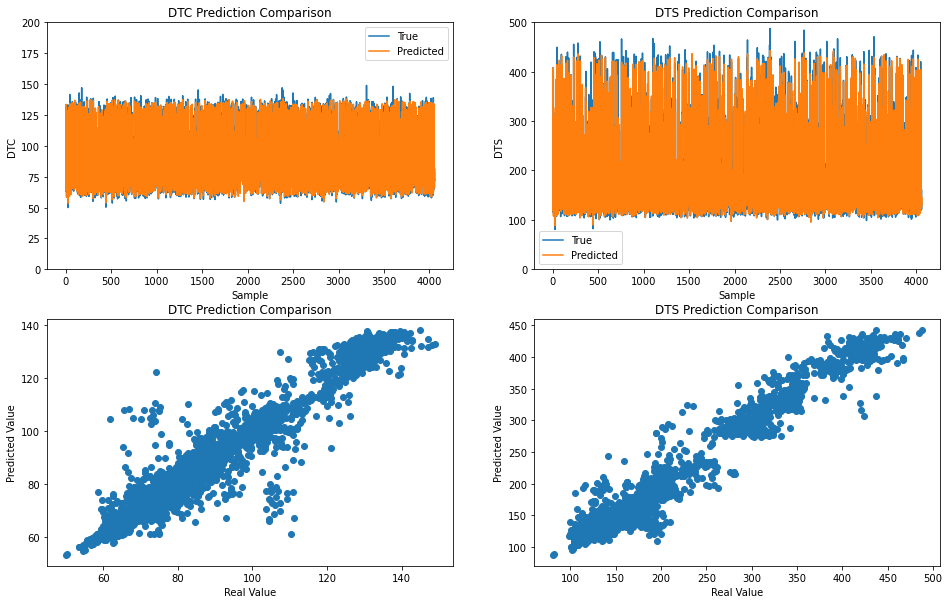

In [207]:
result_plot(y_predict, y_true)

## 6. Model Validation with Test data<a name="Model Validation with Test data"></a>

In [437]:
#check model performance on the test dataset
df2_y = pd.read_csv('real_test_result.csv')

In [438]:
df2_x = df2[['CAL','GR', 'CNC', 'ZDEN', 'PE', 'HRD_log','HRM_log']] 

In [439]:
df2_x_scl = scaler_X.transform(df2_x.values)

Root Mean Square Error is: 28.53781


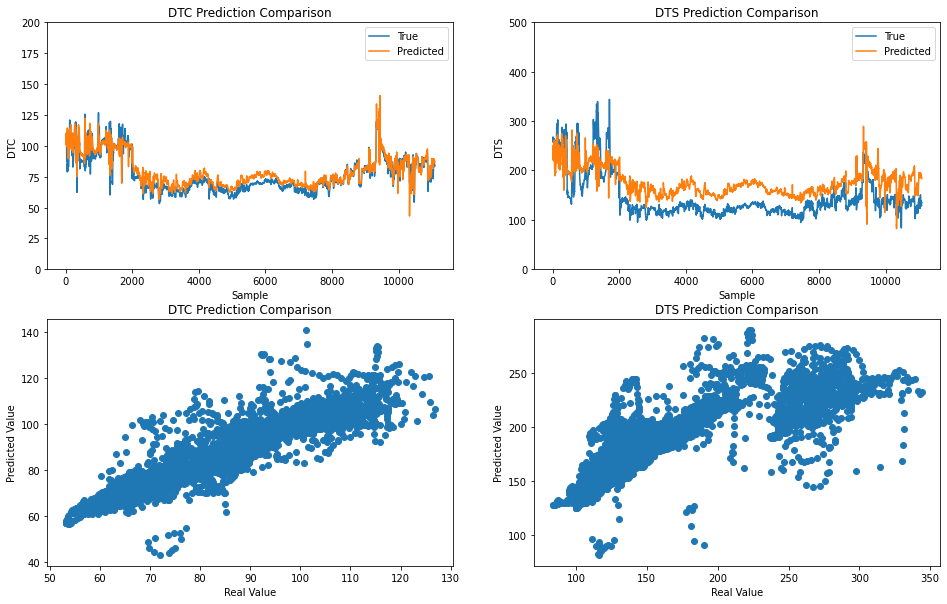

In [221]:
#linear regression
y_predict_test = clf.predict(df2_x_scl)
y_predict_test = scaler_y.inverse_transform(y_predict_test)

result_plot(y_predict_test, df2_y.values)

Root Mean Square Error is: 17.58399


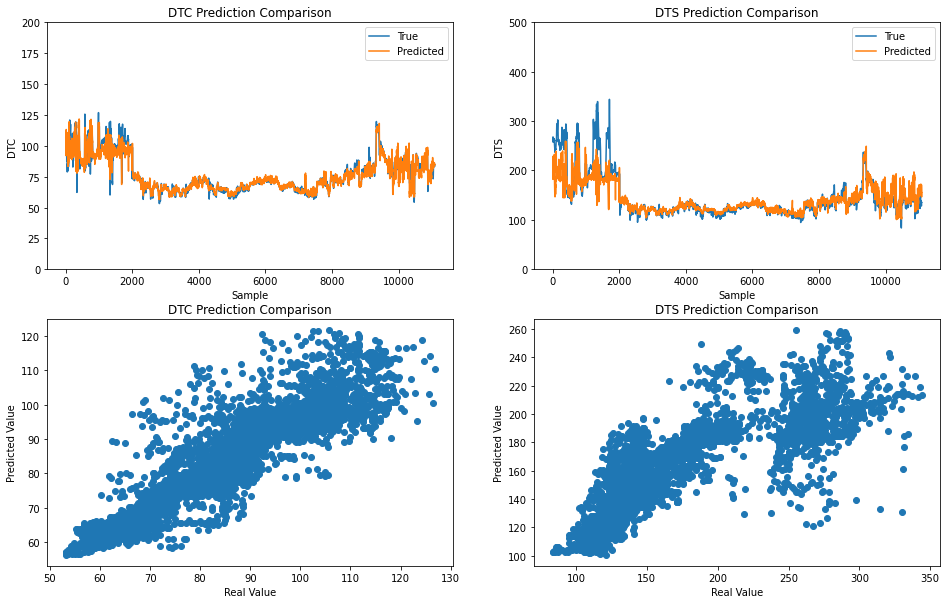

In [374]:
#random forest regression
y_predict_test = RF.predict(df2_x_scl)
y_predict_test = scaler_y.inverse_transform(y_predict_test)

result_plot(y_predict_test, df2_y.values)

Root Mean Square Error is: 17.18240


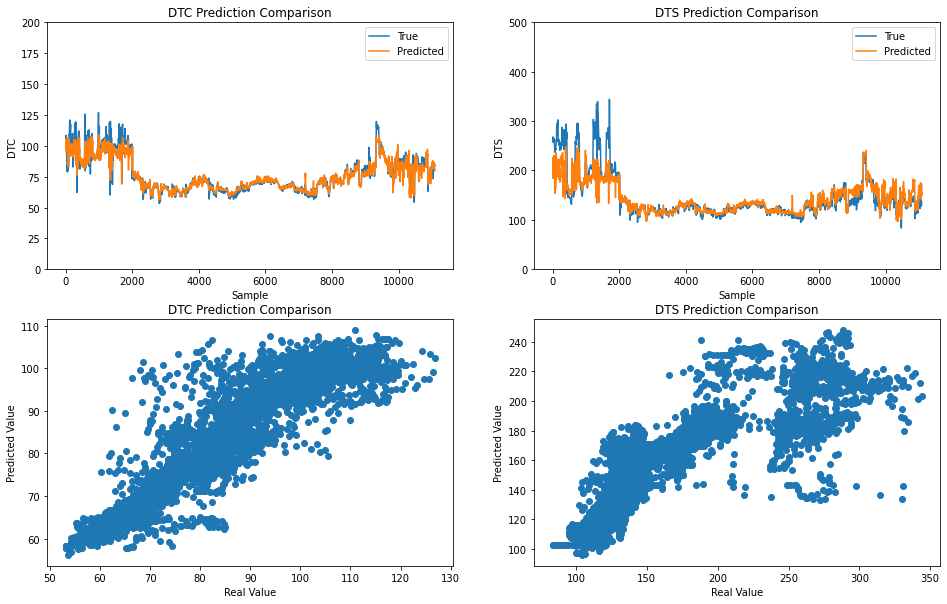

In [440]:
#gradient boosting regression
y_predict_test_dtc=xgb_dtc.predict(df2_x_scl)
y_predict_test_dts=xgb_dts.predict(df2_x_scl)
y_predict_test = np.concatenate((y_predict_test_dtc.reshape(-1,1),y_predict_test_dts.reshape(-1,1)),axis=1)
y_predict_test = scaler_y.inverse_transform(y_predict_test)
result_plot(y_predict_test, df2_y.values)

In [325]:
import shap
# load JS visualization code to notebook
shap.initjs()
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(xgb_dts)

In [346]:
shap_values = explainer.shap_values(df2_x_scl)

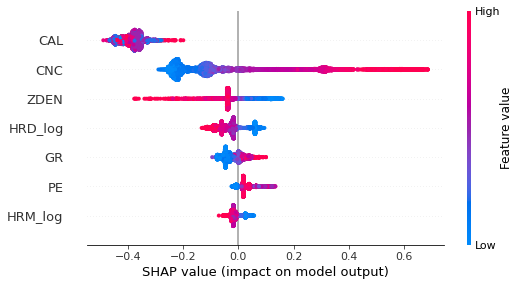

In [347]:
# summarize the effects of all the features
shap.summary_plot(shap_values, df2_x)

In [350]:
low_dts_ix = df2_y.loc[df2_y['DTS  ']<120,:].index.to_list()

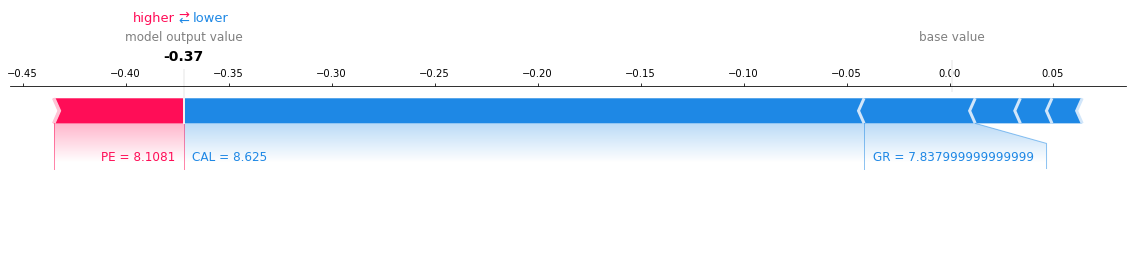

111.9875


In [401]:
i = low_dts_ix[1]
# visualize a specific prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value,shap_values[i,:], df2_x.iloc[i,:],matplotlib=True)
print(df2_y.iloc[i,:]['DTS  '])

In [352]:
high_dts_ix = df2_y.loc[df2_y['DTS  ']>300,:].index.to_list()

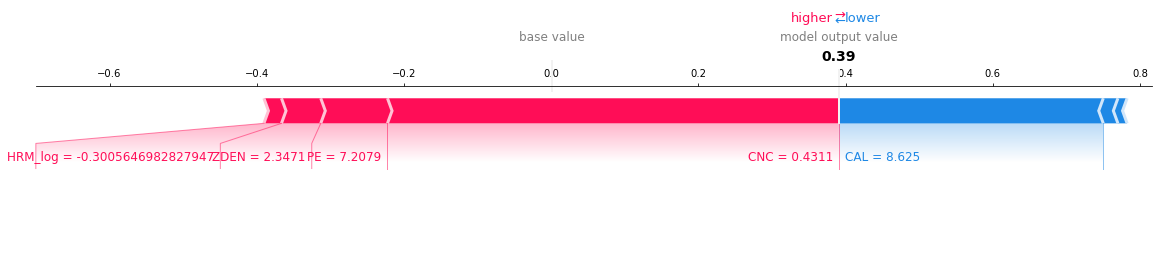

301.9022


In [402]:
i = high_dts_ix[0]
# visualize a specific prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value,shap_values[i,:], df2_x.iloc[i,:],matplotlib=True)
print(df2_y.iloc[i,:]['DTS  '])

Root Mean Square Error is: 21.33698


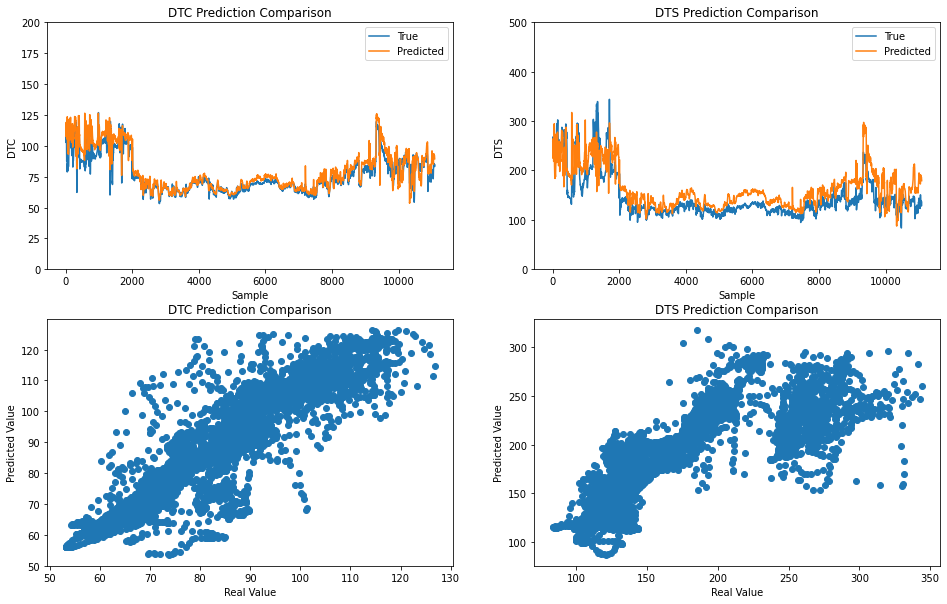

In [241]:
#nueral network
df2_x_mm = scaler_X_mm.transform(df2_x.values)
df2_x_mm =np.concatenate([df2_x_mm[1:-1],df2_x_mm[0:-2],df2_x_mm[2:]],axis=-1) 
y_predict_test = model_1.predict(df2_x_mm)
y_predict_test = scaler_y_mm.inverse_transform(y_predict_test)
result_plot(y_predict_test, df2_y.values[1:-1])

## Summary<a name="Model Validation with Test data"></a>

Among all the tested models, the XGboost regression model delivered the current best result with RMSE 17.58399. Models are able to predict DTC quite closely, as well as the DTS up to 200. The majority errors occured in predicting higher values.

## Lithology Characterization 

In [242]:
def dist_2d(line_start, line_end, point):
    """
    Determine distance between a point to a line marked by starting point and ending point
    Used in litho_chart() function
    """
    line_start = np.asarray(line_start)
    line_end = np.asarray(line_end)
    point = np.asarray(point)
    
    d = linalg.norm(np.cross(line_end-line_start, line_start-point))/linalg.norm(line_end-line_start)
    return d

def litho_chart(NPHI, RHOB, GR, p90):
    """
    Determine a (NPHI, RHOB) point distance towards a CP-1b matrix line
    Return the lithology based on the shortest distance
    Crossplot ref: https://wiki.aapg.org/File:Predicting-reservoir-system-quality-and-performance_fig9-31.png
    Matrix DTC ref:
    - Reservoir:
    https://www.uio.no/studier/emner/matnat/geofag/GEO4250/v08/undervisningsmateriale/Lectures/BWLA%20-%20Porosity%20Logs.pdf 
    using us/ft
    - Shale: https://www.spec2000.net/13-lithdn.htm using us/ft in kaolinite
    
    TODO: 
    - use equation instead of 2 lines (to capture dolomite nonlinearity). 
    - add more lithology line
    - automate the percentile calculation
    """
    if math.isnan(NPHI) or math.isnan(RHOB) or math.isnan(GR):
        return np.nan
    elif GR >= p90:
        #return 'Shale'
        return 3
    else:
        sst_line_start = (-0.02, 2.65)
        sst_line_end = (0.35, 2)

        lst_line_start = (0, 2.71)
        lst_line_end = (0.4, 2)

        dol_line_start = (0.02, 2.87)
        dol_line_end = (0.43, 2.14)

        dist_to_sst = dist_2d(sst_line_start, sst_line_end, (NPHI, RHOB))
        dist_to_lst = dist_2d(lst_line_start, lst_line_end, (NPHI, RHOB))
        dist_to_dol = dist_2d(dol_line_start, dol_line_end, (NPHI, RHOB))
        
        if dist_to_sst < dist_to_lst and dist_to_sst < dist_to_dol:
#             return 182
#             return 55.5
            #return 'Sandstone'
            return 2
        
        elif dist_to_lst < dist_to_sst and dist_to_lst < dist_to_dol:
#             return 155
#             return 47.5
            #return 'Limestone'
            return 0
        elif dist_to_dol < dist_to_sst and dist_to_dol < dist_to_lst:
#             return 144
#             return 43.5
            #return 'Dolomite'
            return 1
        else:
            return np.nan

In [247]:
df1['zone'] = df1.apply(lambda df: litho_chart(NPHI = df.CNC, RHOB = df.ZDEN, GR = df.GR, p90 = 90), axis = 1)
df2['zone'] = df2.apply(lambda df: litho_chart(NPHI = df.CNC, RHOB = df.ZDEN, GR = df.GR, p90 = 90), axis = 1)

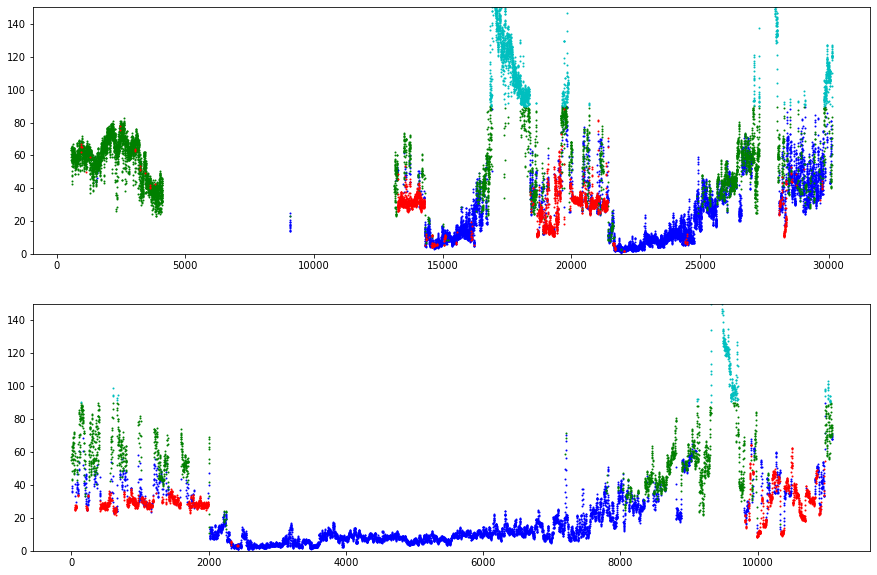

In [248]:
# Figures show the patterns of gamma ray for different zones
co=['b','g','r','c','m','y']
plt.figure(figsize=(15,10))
for i in range(4):
    plt.subplot(2, 1, 1)
    plt.scatter(df1.index[df1.zone.values==i],df1.GR.values[df1.zone.values==i],s=1,color=co[i])
    plt.ylim([0,150])
    plt.subplot(2, 1, 2)
    plt.scatter(df2.index[df2.zone.values==i],df2.GR.values[df2.zone.values==i],s=1,color=co[i])
    plt.ylim([0,150])

In [359]:
#seperate the features and targes
df11_y = df1[['DTC','DTS']]
df11_x = df1[['CAL','GR', 'CNC', 'ZDEN', 'PE', 'HRD_log','HRM_log','zone']] 

In [360]:
#standize the matrix for training data
# Minmax scaling is used to constrain the range of the output.
scaler_X11 = StandardScaler() 
scaler_y11 = StandardScaler() 
x_scl11 = scaler_X11.fit_transform(df11_x.values)   
y_scl11 = scaler_y11.fit_transform(df11_y.values)

In [361]:
#train/test split
X_train11, X_test11, y_train11, y_test11 = train_test_split(x_scl11, y_scl11, test_size = 0.2, random_state = 22)

In [362]:
#model for DCT
y_train_dtc11 = y_train11[:,-2]
xgb_dtc11 = xgb.XGBRegressor(random_state=42, max_depth=5,learning_rate=0.18, n_estimators=145, min_child_weight = 6, gamma = 0.3)
xgb_dtc11.fit(X_train11, y_train_dtc11)
y_predict_dtc11=xgb_dtc11.predict(X_test11)

#model for DTS
y_train_dts11 = y_train11[:,-1]
xgb_dts11 = xgb.XGBRegressor(random_state=42, max_depth=5,learning_rate=0.18, n_estimators=145, min_child_weight = 6, gamma = 0.3)

xgb_dts11.fit(X_train11, y_train_dts11)

y_predict_dts11=xgb_dts11.predict(X_test11)

y_predict11 = np.concatenate((y_predict_dtc11.reshape(-1,1),y_predict_dts11.reshape(-1,1)),axis=1)

Root Mean Square Error is: 7.49568


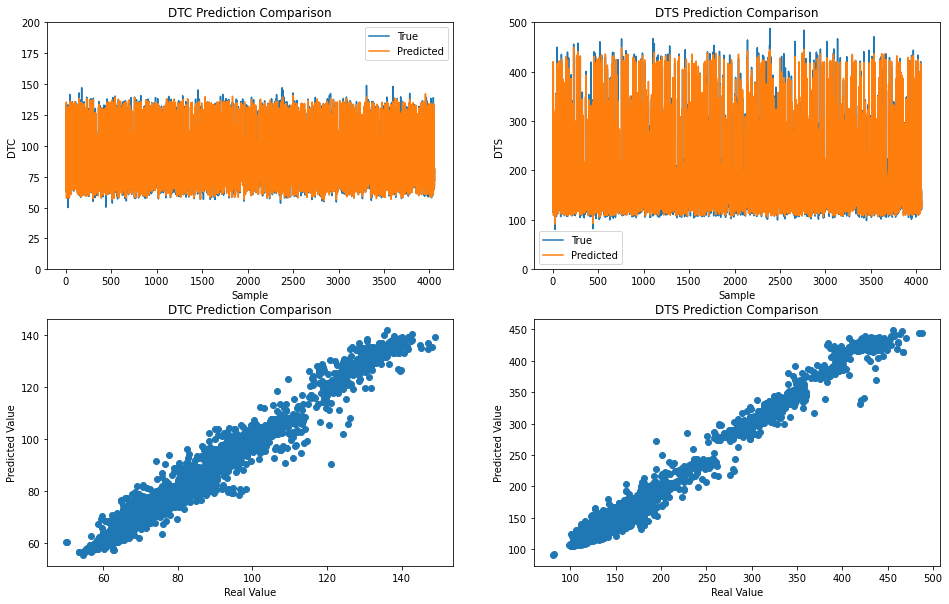

In [363]:
y_predict11 = scaler_y.inverse_transform(y_predict11)
y_true11 = scaler_y11.inverse_transform(y_test11)
result_plot(y_predict11, y_true11)

In [264]:
df11_x_test = df2[['CAL','GR', 'CNC', 'ZDEN', 'PE', 'HRD_log','HRM_log','zone']] 

In [265]:
df11_x_test_scl = scaler_X11.transform(df11_x_test)

Root Mean Square Error is: 16.53824


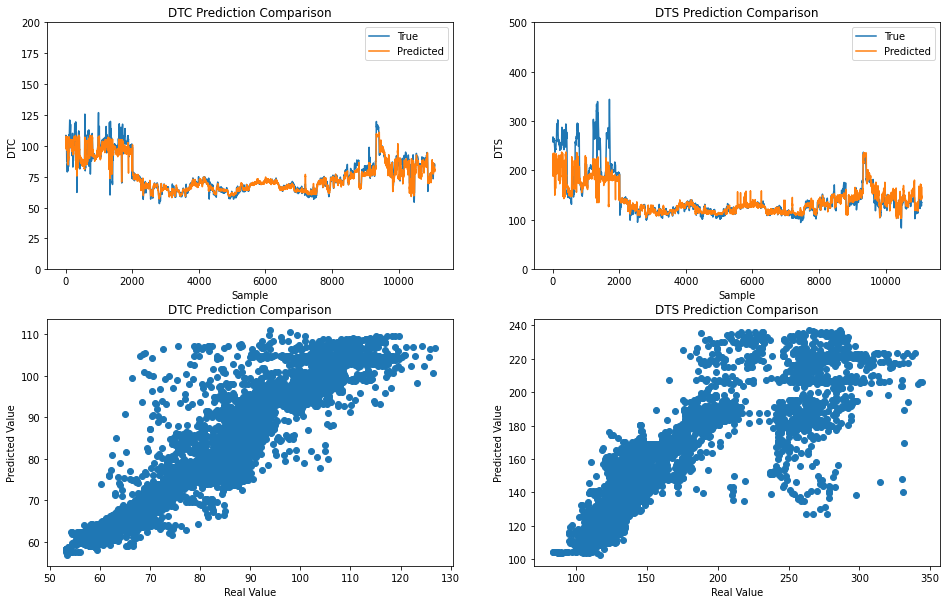

In [273]:
y_predict_test_dtc11=xgb_dtc11.predict(df11_x_test_scl)
y_predict_test_dts11=xgb_dts11.predict(df11_x_test_scl)

y_predict_test11 = np.concatenate((y_predict_test_dtc11.reshape(-1,1),y_predict_test_dts11.reshape(-1,1)),axis=1)
y_predict_test11 = scaler_y.inverse_transform(y_predict_test11)
result_plot(y_predict_test11, df2_y.values)

In [274]:
DTC2=np.zeros(df2.shape[0])# array for saving predictions
DTS2=np.zeros(df2.shape[0])

In [299]:
for iiii in [0,1,2,3]:
    for vel in ['DTC','DTS']:
        df=df1[df1.zone.values==iiii].copy()
        df_test=df2[df2.zone.values==iiii].copy()


        x=df[['CNC','GR','ZDEN','HRD_log','HRM_log','PE','CAL']].copy()
        y=df[[vel]].copy()
      
        scaler_X22 = StandardScaler()
        scaler_y22 = StandardScaler()
        x_train22 = scaler_X22.fit_transform(x.values)        
        y_train22 = scaler_y22.fit_transform(y.values)      

        #same operations are applied to test set.
        x_test=df_test[['CNC','GR','ZDEN','HRD_log','HRM_log','PE','CAL']].copy()#,'RM_log'
        x_test22=scaler_X22.transform(x_test.values)
       

        # gradient boosting model
        if vel == 'DTC':
            xgb22 = xgb.XGBRegressor(random_state=42, max_depth=5,learning_rate=0.18, n_estimators=145, min_child_weight = 6, gamma = 0.3)
        else:
            xgb22 = xgb.XGBRegressor(random_state=42, max_depth=7,learning_rate=0.19, n_estimators=135, min_child_weight = 6, gamma = 0.7)    
        xgb22.fit(x_train22, y_train22)
        y_test22=xgb22.predict(x_test22)
        y_test22=scaler_y22.inverse_transform(y_test22)
        print(df_test.shape, y_test22.shape)
        if vel == 'DTC':
            DTC2[df2.zone.values==iiii]=y_test22
        elif vel == 'DTS':
            DTS2[df2.zone.values==iiii]=y_test22

(7215, 10) (7215,)
(7215, 10) (7215,)
(1734, 10) (1734,)
(1734, 10) (1734,)
(1730, 10) (1730,)
(1730, 10) (1730,)
(409, 10) (409,)
(409, 10) (409,)


In [300]:
y_predict_test22 = np.concatenate((DTC2.reshape(-1,1),DTS2.reshape(-1,1)),axis=1)

Root Mean Square Error is: 16.78107


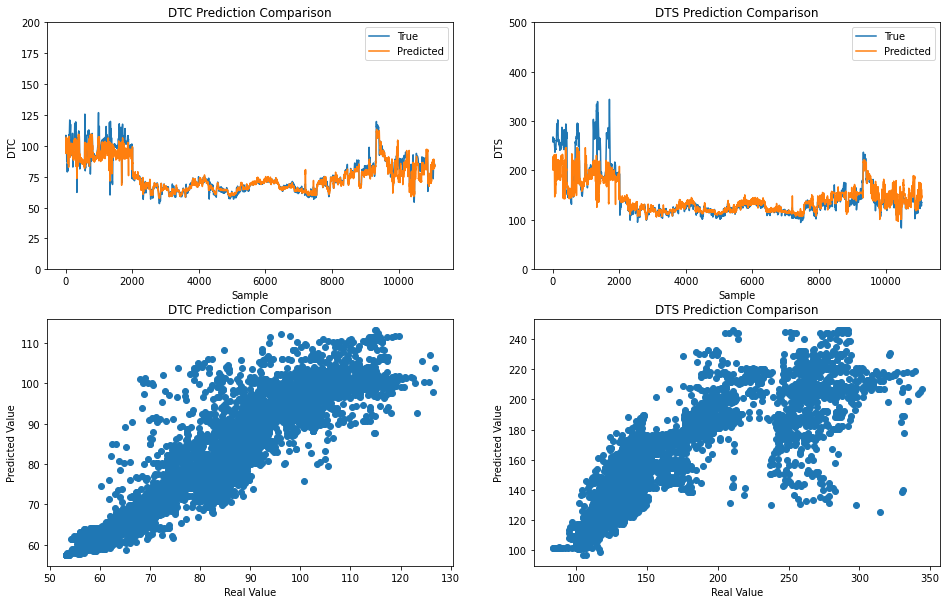

In [301]:
result_plot(y_predict_test22, df2_y.values)